In [1]:
# load modules 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
#input raw data
raw_data = pd.read_json('food_enforcement_US_bacteria.json', orient='records')

In [3]:
print(raw_data.shape)
print(raw_data.head(10).product_description)

(6104, 26)
0    Native Catch Salmon Bacon, Traditional flavor....
1    Delish Fruit Burst 10 oz.(283 g)  Enjoy by: 8/...
2    Garden Pure Holiday Fruit Bowl 4 lbs (1.81kg) ...
3    Fresh Fruit Product is labeled in part:  "***F...
4    Ready Pac¿ Gourmet Fruit Bowl, 64oz , UPC 7774...
5    River Ranch brand Diced Grn Cabbage w/Color, 4...
6    Sweet and Sour Stir Fry packaged under the fol...
7    Onion Slab Cut.  Products are labeled in part:...
8    MIX w/yellow onions used as an ingredient.  Pr...
9    Fresh n Easy brand Shred Grn Cabbage w/Color, ...
Name: product_description, dtype: object


### Clean and lemmatize text + TF-IDF vectorize

In [41]:
# class objects
stops = stopwords.words('english')
tfidf = TfidfVectorizer(stop_words = 'english', ngram_range = (1,2)) # add unigrams and bigrams
lemmer = WordNetLemmatizer()

In [42]:
# add stop words after analysis 
stops.extend(('oz', 'upc', 'lb', 'bag', 'package', 'net', 'upc', 'gallon', 'pint', 'ml', 'wei', 'plastic','inc', 'b', 
              'com', 'code', 'department', 'wt', 'number', 'industry', 'ia', 'irwindale', 'usa', 'earlier', 'wei',
             'quart', 'august', 'mamaroneck', 'food', 'imp', 'gl', 'sff', 'description', 'gram', 'weight', 
             'brand', 'label', 'fc', 'ounce', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id', 
              'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh',
              'nj', 'ny', 'nm', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va',
              'wa', 'wv', 'wi', 'wy', 'item', 'pkgs', 'distribute', 'brooklyn', 'lb', 'jefferson', 'dist', 'com', 'c',
              'beaverton', 'retail', 'determine', 'unable', 'sell', 'snoqualmie', 'gc', 'unit', 'seattle', 'albertson', 
              'kg','cambridge', 'warrensburg', 'op', 'lg', 'rom', 'bentonville', 'chapel', 'hill', 'swainsboro', 'lb',
              'www', 'iff', 'wei', 'aurora', 'harris', 'bi', 'lo', 'gal', 'qts', 'gh', 'llc','springfield', 'label', 'x',
              'kg', 'po', 'al', 'birmingham','princeton','dz', 'institutional','mb','pleasanton','wei','richfield', 'g', 'per'
             ))

In [43]:
# Define function get_pos
# Map POS tag to first character lemmatize() accepts

def get_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

In [44]:
# Define function kleenex
# Cleans, lemmatizes, and removes stop words 

def kleenex(d):
    tmp = []
    for t in d:
        if type(t) == str:
            w = re.sub("[^A-Za-z]+", " ", t) # remove non-letters
            w = w.lower() # lower class
            w = w.strip() # remove spaces
            w = word_tokenize(w) # tokenize words
            w = [lemmer.lemmatize(wrd, get_pos(wrd)) for wrd in w if wrd not in stops] #lemmatize word
            w = " ".join(w)
            tmp.append(w)
        #else:
        #    tmp.append(None)
    return(tmp)

In [45]:
# Build corpus
corpus = raw_data['product_description']

# Clean Corpus
X = kleenex(corpus)

In [46]:
# TF-IDF transformation
Xtrans = tfidf.fit_transform(X)

# get tf idf feature names 
words = tfidf.get_feature_names()

# tf-idf shape
Xtrans.shape


(6104, 32375)

### fit Kmeans and find optimal number of clusters

In [47]:
# fitting K means to view change in Inertia
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# container and number of clusters 
distortions = []
#NCs = (10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200)
NCs = (6,12,18,24,30,36,42,48,54,60,66,72,78,84,90,96,102,108,114,120)
km = {}
silhouette_coef = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in range(20):
    km[i] = KMeans(n_clusters=NCs[i], n_init=20)
    km[i].fit(Xtrans)
    distortions.append(km[i].inertia_)
    score = silhouette_score(Xtrans, km[i].labels_)
    silhouette_coef.append(score) 

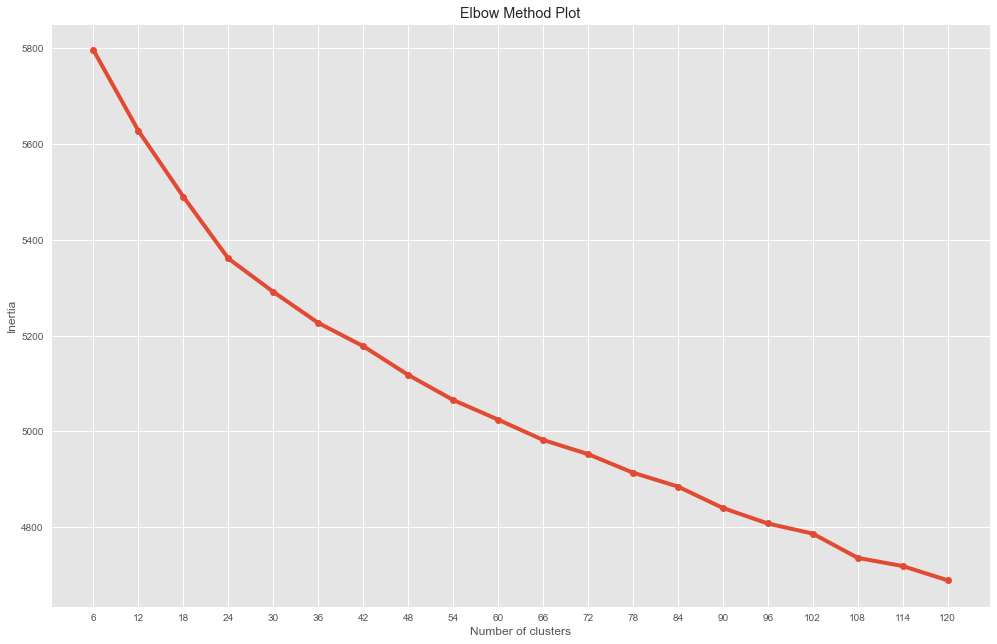

In [48]:
# vizualize change in inertia
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

plt.plot(range(20), distortions, marker='o')
plt.title('Elbow Method Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(20), NCs)
plt.show()

In [49]:
# locate the elbow

from kneed import KneeLocator

kl = KneeLocator(NCs, distortions, curve="convex", direction="decreasing")

kl.elbow


48

### Plot Silhouette score

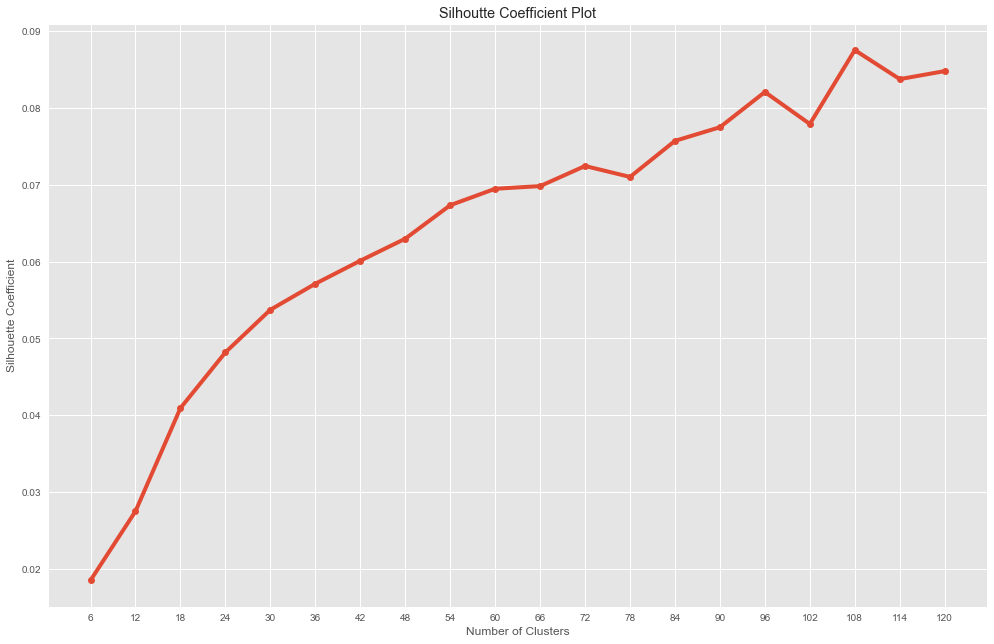

In [50]:

plt.figure(figsize=(15,10))

plt.plot(range(20), silhouette_coef, marker='o')
plt.title('Silhoutte Coefficient Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.xticks(range(20), NCs)
plt.show()


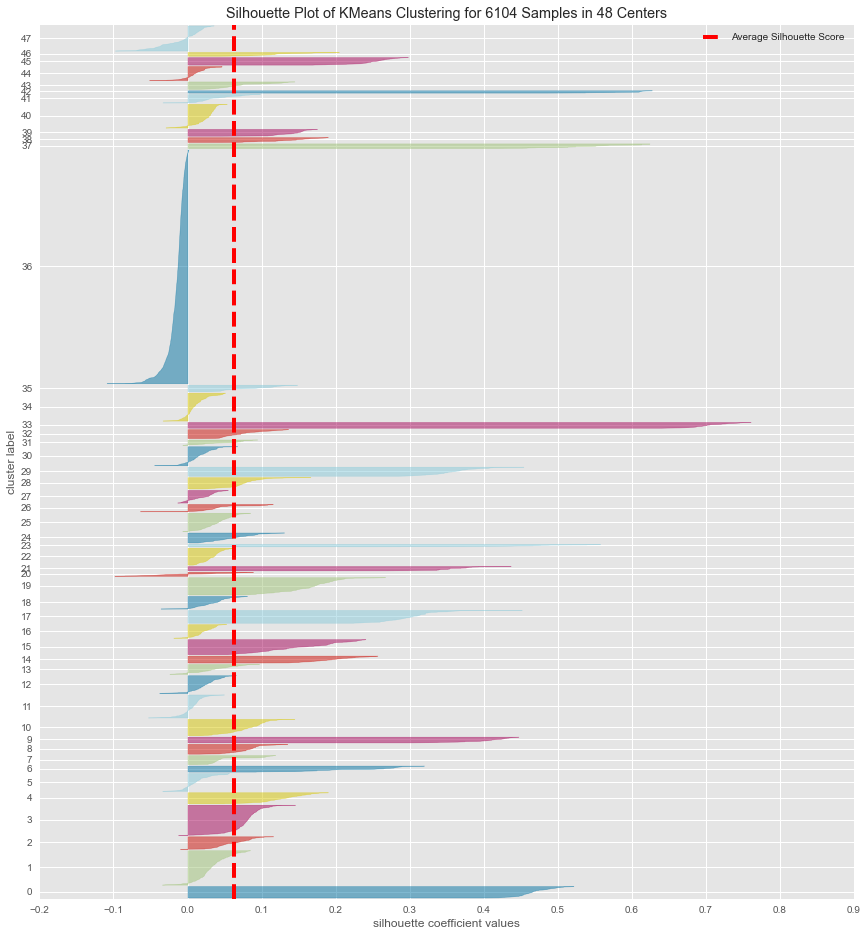

In [122]:
# from yellowbrick.cluster import SilhouetteVisualizer

plt.figure(figsize=(13,15))

visualizer = SilhouetteVisualizer(km[7], colors='yellowbrick')

visualizer.fit(Xtrans)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Plot histogram to see distribution by labels 

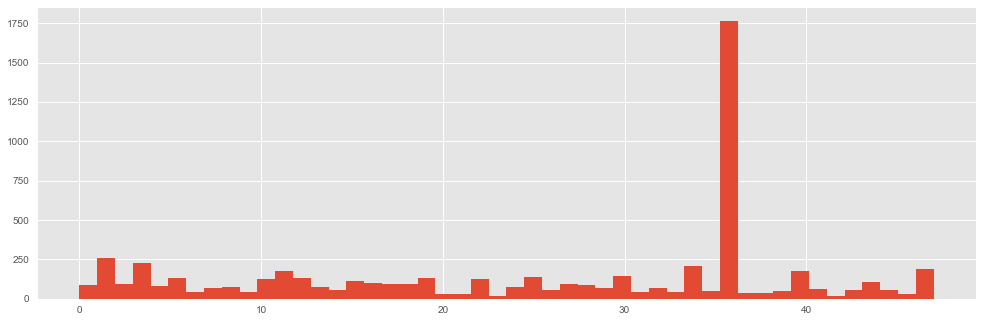

In [121]:
plt.figure(figsize=(15,5))

modelnum = 7
n_cluster = 48

# modelnum = 7
# n_cluster = 48

plt.hist(km[modelnum].labels_, density=False, bins=n_cluster)
plt.show()

### take a look at one of the cluster results

In [102]:
# You should look at all the clusters, but let's look at cluster "15" (I chose this arbitrarily; you should look at all of them)

n=7
cluster= 47


for i in range(0,len(km[n].labels_)):
    if km[n].labels_[i] == cluster:
        print(raw_data['product_description'][i])
        print('**********')

#745 Sandwich - Ham & Cheese	sandwich  
**********
Late July Organic Mini Peanut Butter Sandwich Crackers  packaged in :   5oz box  UPC 890444000700  8ct carton/1.125oz (single serve caddy) & 1.125oz pack (single serve pack UPC: 890444000724 & 890444000717
**********
#742 Sandwich - Tuna Spread	sandwich  
**********
Belfonte Home Run Sundae Ice Cream, A Baseball Nut Blend of Chocolate Peanuts, Chocolate Coated Pretzels, and a Thick Fudge Swirl in Peanut Butter/Chocolate Ice Cream, 56 oz. (1.66L) Belonite Ice Cream Company, Kansas City, MO
**********
#701 Panini - California Turkey	sandwich  
**********
#744 Sandwich - Sandwich Spread	sandwich  
**********
#702 Panini - American Club	sandwich  
**********
#747 Egg Salad Sandwich on White
**********
Moon Pie(R) Crunch Peanut Butter, CRUNCHY chocolate cookie sandwich, NET WT 2.4 oz and 9.6 oz , Baked by Chattanooga Bakery, Inc., Chattanooga, TN  37401  
**********
#704 Panini - Reuben	sandwich  
**********
#705 Panini - Rotisserie Chicken

### Examine top 10 common words by cluster

In [53]:
# Set the top 10 common words in K Means cluster centers 
common_words = km[7].cluster_centers_.argsort()[:,-1:-11:-1]

# print out the results by the 250 clusters 
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : polyethylene, river ranch, ranch, river, salad bag, foodservice polypropylene, refrigerate consume, film foodservice, polyethylene refrigerate, polyethylene film
1 : peanut, peanut butter, butter, sunland, creamy, valencia, crunchy, organic, creamy peanut, natural
2 : pasta, pasta salad, salad, garden, garden fresh, fresh, salad product, product, fine tradition, tradition
3 : blue bell, bell, blue, bell ice, cream, ice cream, ice, chocolate, vanilla, cream chocolate
4 : chocolate, asher, asher chocolate, milk chocolate, chocolate milk, milk, cluster, coat, chocolate dark, dark
5 : cheese, clear, wheel, raw, macadamia, macadamia nut, wrap, nut, package, package clear
6 : parker, snap lid, lid, snap, size brand, sell follow, follow size, parker farm, brand, brand parker
7 : tray, wawa, wawa wawa, flavor production, liter tray, tray product, liter, gelato liter, production, distribute wawa
8 : cole, cole slaw, slaw, safeway store, sell safeway, tray cup, clear tray, store packed, pack

### Understanding the Clusters

In [118]:
# 48 clusters km[7]

raw_data['ClusterNum'] = km[7].labels_

clustering = []

for row in raw_data['ClusterNum']:
    if row == 0:        clustering.append('salads')
    elif row == 1:      clustering.append('peanut related')
    elif row == 2:      clustering.append('pasta or pasta salads')
    elif row == 3:      clustering.append('blue bell ice cream')
    elif row == 4:      clustering.append('chocolate')
    elif row == 5:      clustering.append('packaged nutes & cheese')
    elif row == 6:      clustering.append('parkers farm products')
    elif row == 7:      clustering.append('trayed and wawa products')
    elif row == 8:      clustering.append('cole slaw')
    elif row == 9:      clustering.append('publix products')
    elif row == 10:      clustering.append('raser products')
    elif row == 11:      clustering.append('salted products ++')
    elif row == 12:      clustering.append('nutrition bars')
    elif row == 13:      clustering.append('carton cased salads')
    elif row == 14:      clustering.append('helados la tapatia products')  
    elif row == 15:      clustering.append('snoqualmie products')
    elif row == 16:      clustering.append('potato salads')
    elif row == 17:      clustering.append('favored ice cream')
    elif row == 18:      clustering.append('finist tradtion products')
    elif row == 19:      clustering.append('jeni splendid ice cream')
    elif row == 20:      clustering.append('frozen pops & ice cream with gum')
    elif row == 21:      clustering.append('ossie products')
    elif row == 22:      clustering.append('ham, turkey ++')  
    elif row == 23:      clustering.append('dr praeger products')
    elif row == 24:      clustering.append('onion products')
    elif row == 25:      clustering.append('smoked salmon')
    elif row == 26:      clustering.append('spreads')
    elif row == 27:      clustering.append('vacuum packed products')
    elif row == 28:      clustering.append('whole foods products')
    elif row == 29:      clustering.append('cardboard packaged ice cream')
    elif row == 30:      clustering.append('nut mix')  
    elif row == 31:      clustering.append('salsa ++')
    elif row == 32:      clustering.append('ready packed frozen products')
    elif row == 33:      clustering.append('husky deli ice cream')
    elif row == 34:      clustering.append('organic products')
    elif row == 35:      clustering.append('cheese')
    elif row == 36:      clustering.append('others - kitchen sink cluster')
    elif row == 37:      clustering.append('bueno gc products')
    elif row == 38:      clustering.append('gh foods products')  
    elif row == 39:      clustering.append('packaged nuts') 
    elif row == 40:      clustering.append('garden fresh products')
    elif row == 41:      clustering.append('almond products')
    elif row == 42:      clustering.append('ready chef go products')
    elif row == 43:      clustering.append('gills onions + integrated food products')
    elif row == 44:      clustering.append('products with beans')
    elif row == 45:      clustering.append('fresh frozen products')
    elif row == 46:      clustering.append('potato salad 2')  
    elif row == 47:      clustering.append('ice cream sandwich + sanwich ++')

raw_data['ClusterName'] = clustering

print(raw_data.ClusterName.head(20))

0                     smoked salmon
1     others - kitchen sink cluster
2     others - kitchen sink cluster
3     others - kitchen sink cluster
4     others - kitchen sink cluster
5                            salads
6                 gh foods products
7                    onion products
8                    onion products
9                            salads
10                           salads
11                   onion products
12                           salads
13                           salads
14                           salads
15                   onion products
16                           salads
17                           salads
18                gh foods products
19                gh foods products
Name: ClusterName, dtype: object


# Summary of Work and Results using K Means Clustering

### Data cleaning and Initial Clustering 

I first carried out data cleaning of the text by removing stop-words, non-letters and spaces, lower-case trasnforming, tokenizing and then lemmatizing the words for analysis using the **nltk module**. The corpus was then analyzed with the **TFIDFVectorizer with both unigrams and bigrams**. With these features, I carried out k-means clustering with number of clusters initial from 2 to up to 400. The result showed that there were no clear elbow in the inertia plot where the inertia rates continue to gradually decrease with the increase in number of clusters. However, with more clusters, the clustering becomes inefficient and impractical for use and analysis. 

After the first pass, I also recongized that there were a number of words that were common but not specifically relevant for the clustering by food categories. These included weight figures such as 'oz', 'lbs' or location and state names and others. Hence, I added these to the stop-word list to remove in the data cleaning stage. 

### K-means cluster optimization

As for the number of clusters, I decided to find the optimum value from 6 to 120 to make the clusters practical. To check the results, I used the Elbow Plot and Silhoutte Scores plus the Silhoutte Visualizer to find the optimum number of clusters. Based on the KneeLocator, the knee is suggested at 48, which is a managable number of food categories. The silhoutte visualizer also showed results that were majority positive, with only a handful of negative items. However, I did recognize a sizable left-over cluster or kitchen sink cluster that also had a large negative silhoutte score. 

In addition, I looked at the distribution of items in each cluster using a histogram, which showed that all clusters had a 250 or less items per cluster. However, the kitchen sink cluster had sizable number of 1750 or so items. This left-over cluster does slowly reduce when increasing the number of clusters. For instance, with 120 clusters, the kitchen sink cluster reduces to some 950 items. However, the number of clusters becomes difficult to manage with a lot of overlapping clusters as well. Hence, the trade-off in efficiency does not seem to merit increasing the number of clusters for reducing the left-over clusters. 

**Therefore, I decided to use 48 clusters as recommended by the elbow plot and through examination of the silhoutte sources and its impact on the clustering exercise.** 

### Clustering Results and Examples

The final clustering of 48 clusters provide coherent and identifiable clusters for almost all clusters apart from the kitchen-sink cluster, cluster 36. In most cases, the clusters are related to certain food types such as salads, peanuts, salmon, chocolate or are products from the same producer such as parker farm, helados la tapatia, whole foods, ossie products. Considering that these are for food recalls, clustering by food types or producer both seems to make sense. 

There are a few clusters that have some overlap, but are understandable or useful overlaps. For instance, there are at least 7 different ice cream clusters. But all of them seem to have certain differences in terms of producer or type of ice cream: 

    Blue Bell ice cream(#3), favored ice cream (#17), Jeni's Splendid Ice Cream (#19), Ice cream with Gum (#20), cardboard packaged ice cream (#29), Husky Deli Ice cream (#33), Ice cream sandwiches (#47)

There were also two different potato salad clusters, but without as clear of a distinction. Over than these, there were some 4 clusters (numbers 11, 22, 31, 47) that had certain themes such as salted products, salsa related, include ham and/or turkey, or sanwich-related, but with items that did not full fit into these clusters as well. Hence, I put '++' marks in the names of these clusters to mark clearly.

All in all, the clustering seems to work well and seem to provide a good point in the trade-off between efficiency and effectiveness. I coded the cluster numbers and names in the raw data folder for later usage and analysis as well. 

<br><br><br><br>

***

# ANNEX: Comparing K Mean with Thematic Extraction Using Gensim LDA

In [103]:
# Gensim
import gensim
import gensim.corpora as corpora
import pyLDAvis.gensim

#Data Viz
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label, ColumnDataSource
from bokeh.io import output_notebook
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [112]:
# Thematic extraction prep
x_token = list()

for word in X:
    x_token.append(word.split(" "))

In [114]:
# Thematic extraction
First = corpora.Dictionary(x_token)
corp = [First.doc2bow(text) for text in x_token]

ldamod = gensim.models.ldamodel.LdaModel(corp, num_topics = 30, id2word = First, passes = 45)
First_topics = ldamod.print_topics(num_words = 5)

print("Product recall topics")
for topic in First_topics:
    print(topic)

Product recall topics
(4, '0.241*"organic" + 0.104*"sweet" + 0.061*"season" + 0.055*"whole" + 0.045*"nature"')
(0, '0.161*"broccoli" + 0.133*"cauliflower" + 0.130*"floret" + 0.068*"slaw" + 0.045*"cole"')
(2, '0.272*"apple" + 0.153*"frozen" + 0.104*"slice" + 0.091*"fresh" + 0.042*"dice"')
(20, '0.241*"cream" + 0.182*"ice" + 0.057*"frozen" + 0.051*"container" + 0.038*"blue"')
(26, '0.175*"fresh" + 0.115*"garden" + 0.085*"salad" + 0.061*"product" + 0.043*"giant"')
(18, '0.059*"corn" + 0.055*"salt" + 0.052*"ingredient" + 0.047*"milk" + 0.037*"soy"')
(7, '0.094*"cup" + 0.075*"sell" + 0.066*"store" + 0.063*"best" + 0.062*"packed"')
(10, '0.210*"pack" + 0.110*"variety" + 0.056*"r" + 0.038*"cranberry" + 0.037*"follow"')
(8, '0.127*"individual" + 0.125*"cheese" + 0.054*"kernel" + 0.051*"raw" + 0.048*"roast"')
(12, '0.080*"onion" + 0.066*"individually" + 0.054*"bucket" + 0.031*"yellow" + 0.031*"part"')
(13, '0.085*"hummus" + 0.060*"snack" + 0.054*"party" + 0.050*"trader" + 0.050*"joe"')
(1, '0.1

In [106]:
# Data Viz
vis = pyLDAvis.gensim.prepare(ldamod, corp, dictionary=ldamod.id2word)
pyLDAvis.display(vis)

In [107]:
# dominant topics for each entry


def format_topics_sentences(ldamodel=None, corpus=corp, texts=x_token):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_keywords = format_topics_sentences(ldamodel=ldamod, corpus=corp, texts=X)

# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,28.0,0.2245,"n, catch, pecan, cashew, hand, herring, wester...",native catch salmon bacon traditional flavor t...
1,1,12.0,0.4195,"mix, onion, dice, snack, chip, yellow, eagle, ...",delish fruit burst enjoy distribute walgreen w...
2,2,23.0,0.2528,"vegetable, mixed, product, include, italian, r...",garden pure holiday fruit bowl lb best f produ...
3,3,5.0,0.1731,"price, carob, pic, top, cake, pack, mango, fiv...",fresh fruit product label part fresh island me...
4,4,23.0,0.2767,"vegetable, mixed, product, include, italian, r...",ready pac gourmet fruit bowl use date
5,5,14.0,0.9688,"best, date, ranch, product, use, river, polyet...",river ranch dice grn cabbage w color n product...
6,6,24.0,0.5341,"cheese, pepper, red, pound, package, wheel, fo...",sweet sour stir fry package follow name size g...
7,7,12.0,0.3874,"mix, onion, dice, snack, chip, yellow, eagle, ...",onion slab cut product label part onion yellow...
8,8,19.0,0.4868,"organic, bucket, whole, product, package, mark...",mix w yellow onion use ingredient product may ...
9,9,14.0,0.9688,"best, date, ranch, product, use, river, polyet...",fresh n easy shred grn cabbage w color n produ...


In [110]:
# You should look at all the clusters, but let's look at cluster "15" (I chose this arbitrarily; you should look at all of them)

topic=2

for i in range(0,len(df_dominant_topic.Dominant_Topic)):
    if df_dominant_topic.Dominant_Topic[i] == topic:
        print(raw_data['product_description'][i])
        print('**********')

Clams, Frozen Boiled Baby, in shell, 10 oz packages, 24 pkgs/carton, item #20699K. UPC 081652 206996.
**********
Cut N Clean Greens Comfort Greens Kit, Ready-to-Cook Kit, 24 oz. Packaged in 24 oz plastic clamshell at 6 per case.    This product is sold as a 24oz clamshell (plastic container with lid) cooking greens kit. Product is identifiable by the UPC Number 028764000616 this is located on the back label of the product.     Product labeling reads in part:" Cut N Clean Greens COMFORT GREENS KIT Complete with collard, mustard and turnip greens, bacon, red cabbage, sweet onion and seasoning  Ready-to-Cook Kit NET WT 680g 24 oz***Produce of U.S.A.***SAN MIGUEL PRODUCE, INC. Grown in Ventura County, California U.S.A.***".
**********
Apple Slices & Fat Free Caramel Dip contained in the Armour Active Packs Cheese Pizza Lunch Kit
**********
Organic Chamomile Tea Bag Cut (TBC) bulk sold in original cases (25kg bags), Bulk product 25 kg craft paper bags    "L 0609-13681-238641-01 ORGANIC CHAM

# Summary of Work using Gensim LDA method 

Considering the effectiveness of their models, I carried out topical modeling of the corpus using Gensim Latent Dirichlet allocation (LDA). Considering the difficulties with working with a large number of topics, I kept the number of topics at 30 to make it managable. The LDA method does seem to pick up on the main topic areas for the recalled food products, when looking at the distribution plot using pyLDAvis. For instance, you see a strong cluster around 'ice creams', another large cluster around 'salads', as well as clusters around 'chocolate', 'bars' and types of vegetables. These clusters do seem to provide some room for allocating the products into more sizable "topical" clusters. Also, there does not seem to be an apparent kitchen-sink cluster with rather even distribution compared to the K-means clusters. 

However, when trying to identify the dominant topics and using that for clustering, the result does not seem to fit as well as the K Means clustering. This especially seems to be the case for text that are only loosely associated to a certain dominant topic. While LDA is strong in identifying the underlying topic clusters throughout the corpus, there seem to be some limitation in using it for food product categorization at least based on my experimentation of the method. The LDA method might work better in somewhat longer texts rather than simple product labels or descriptions as well. 

Hence, if I had to select, I would prefer using the K Means method to identify the clusters even if there are limits in having a left-over cluster. 
